In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/evilshadow/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Load the data
books = pd.read_csv('books.csv',error_bad_lines=False)

# Display the first few rows
books.head()

# Display the summary statistics
books.describe()


/var/folders/jm/68pl2ckd47g3b2j93y9hndyr0000gn/T/ipykernel_30386/2759392717.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  books = pd.read_csv('books.csv',error_bad_lines=False)
b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


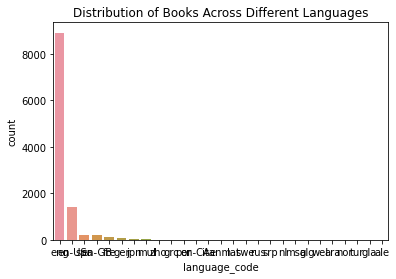

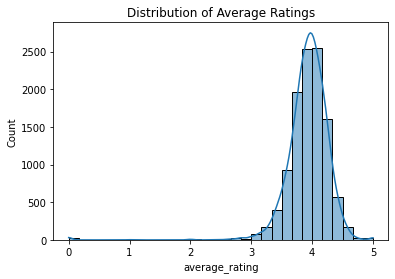

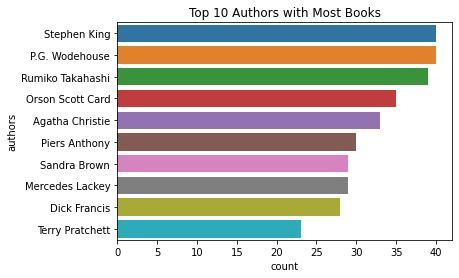

In [7]:
# Distribution of books across different languages
books_lang = books['language_code'].value_counts().reset_index()
books_lang.columns = ['language_code', 'count']
sns.barplot(x='language_code', y='count', data=books_lang)
plt.title('Distribution of Books Across Different Languages')
plt.show()

# Distribution of average ratings
sns.histplot(books['average_rating'], kde=True, bins=30)
plt.title('Distribution of Average Ratings')
plt.show()

# Top 10 authors with most books
top_authors = books['authors'].value_counts()[:10].reset_index()
top_authors.columns = ['authors', 'count']
sns.barplot(x='count', y='authors', data=top_authors)
plt.title('Top 10 Authors with Most Books')
plt.show()


In [8]:
# Combine title and author into a single feature
books['title_author'] = books['title'] + " " + books['authors']


In [9]:
# Calculate the mean average rating and the minimum number of ratings required to be in the top 5%
mean_average_rating = books['average_rating'].mean()
min_ratings = books['ratings_count'].quantile(0.95)

# Function to calculate the weighted rating of each book
def weighted_rating(x, m=min_ratings, C=mean_average_rating):
    v = x['ratings_count']
    R = x['average_rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

# Apply the function to calculate the 'score' of each book
books['score'] = books.apply(weighted_rating, axis=1)


In [10]:
# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))

# Fit and transform the 'title_author' feature
tfidf_matrix = vectorizer.fit_transform(books['title_author'])


In [11]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


In [12]:
# Create a reverse mapping of indices and book titles
indices = pd.Series(books.index, index=books['title']).drop_duplicates()

def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    book_indices = [i[0] for i in sim_scores]
    return books['title'].iloc[book_indices]


In [16]:
# Test the function with a popular book title
print(get_recommendations('Northern Lights'))


11084             Northern Lights (His Dark Materials  #1)
1015                              In the Lake of the Woods
1016                                       The Nuclear Age
1014                                  Going After Cacciato
6473     His Dark Materials Trilogy (Northern Lights; T...
1641                             If I Die in a Combat Zone
1642                             If I Die In A Combat Zone
7084                                            Lights Out
1013     If I Die in a Combat Zone  Box Me Up and Ship ...
6787                                       Z for Zachariah
Name: title, dtype: object
